# Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Flatten, Input,MaxPool2D,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


# Preprocessing

In [3]:
data_directory = '/kaggle/input/teeth-dataset/Teeth_Dataset/'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Training",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Validation",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory + "Testing",
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

class_names = train_dataset.class_names
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))
print("Number of Batches:", len(train_dataset))

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Class Names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of Classes: 7
Number of Batches: 97


In [4]:
def plot_class_distribution(dataset, title):
    class_names = dataset.class_names
    class_counts = [0] * len(class_names)
    
    for _, labels in dataset:
        for label in labels:
            class_counts[label] += 1
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts, color='skyblue')
    plt.title(f'Class Distribution in {title} Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

def display_sample_images(dataset, title, num_images=9):
    class_names = dataset.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle(f'Sample Images from {title} Dataset')
    plt.show()


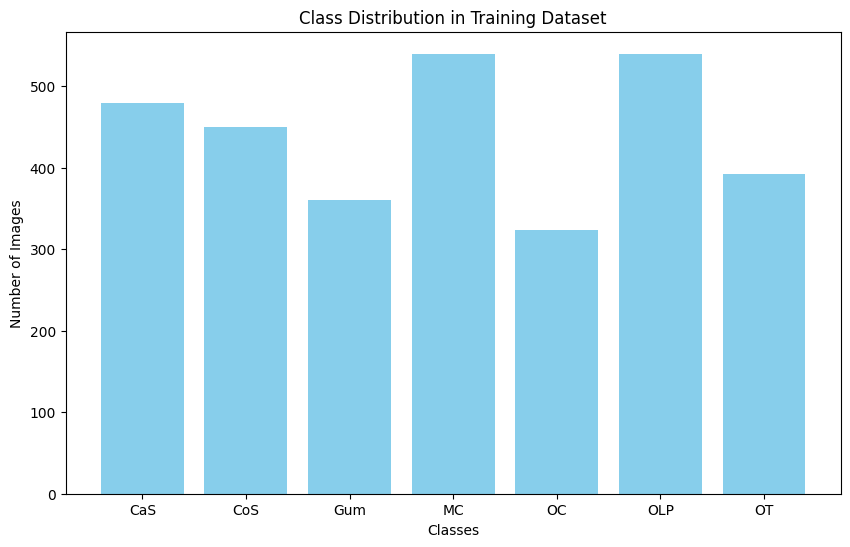

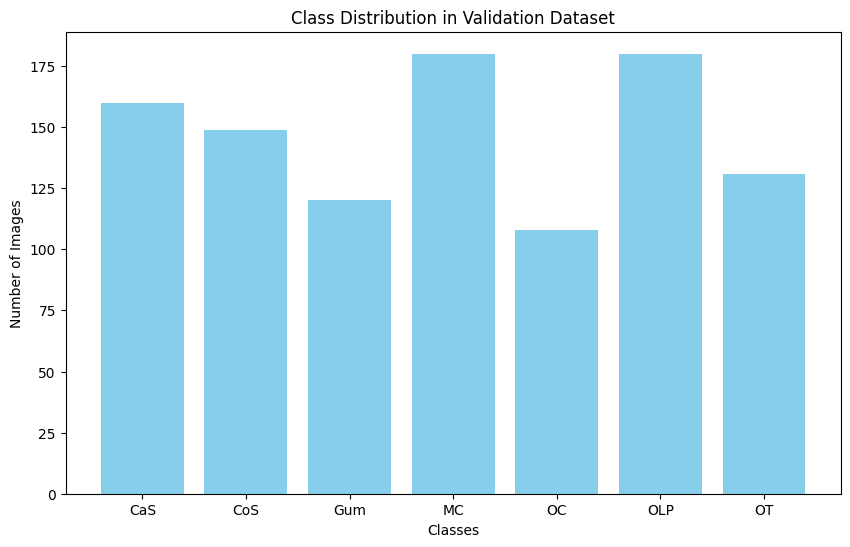

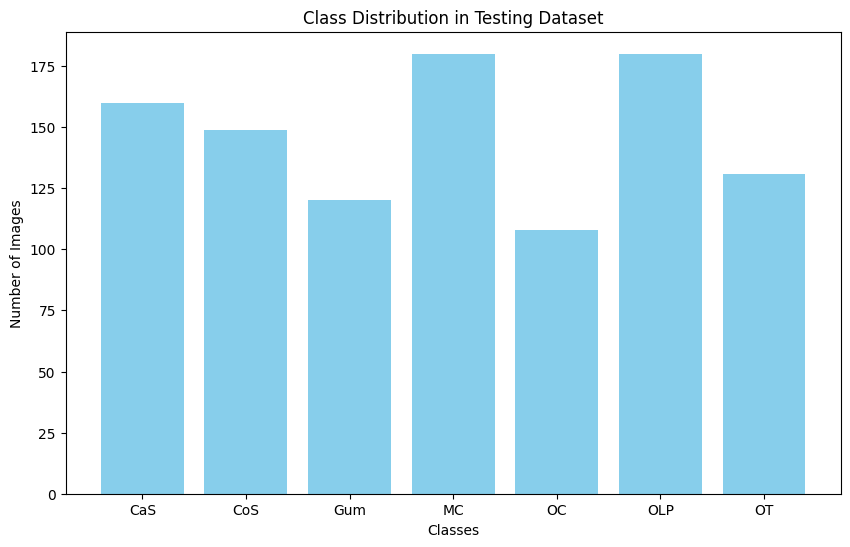

In [5]:
plot_class_distribution(train_dataset, "Training")
plot_class_distribution(validation_dataset, "Validation")
plot_class_distribution(test_dataset, "Testing")

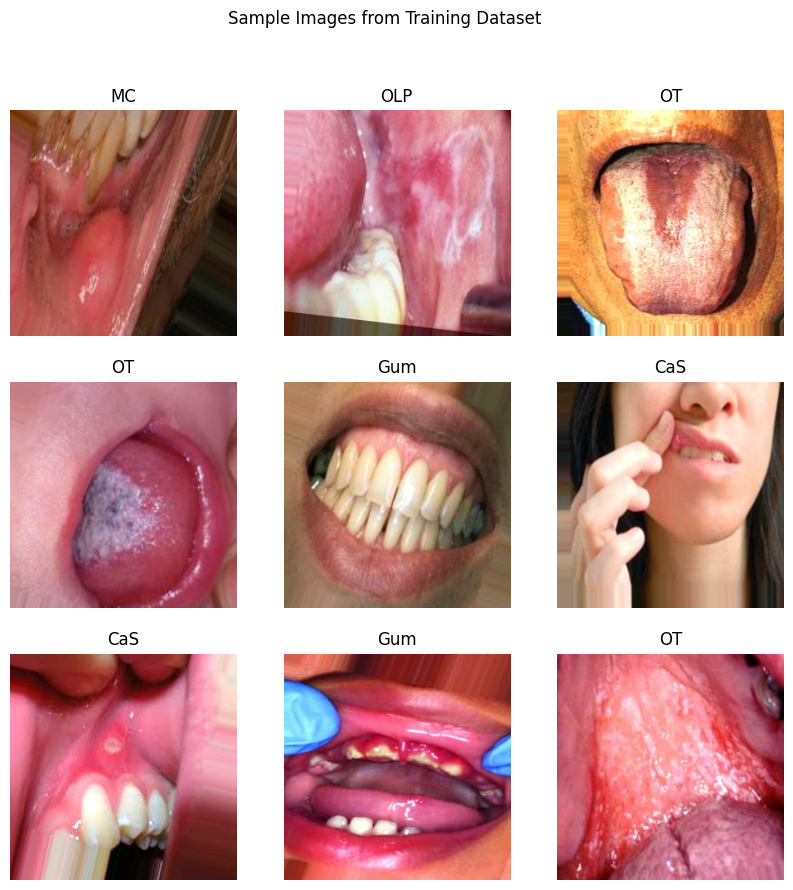

In [6]:
display_sample_images(train_dataset, "Training")

In [8]:
augmentation_layer = Sequential([
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    tf.keras.layers.RandomContrast(factor=0.2),
])

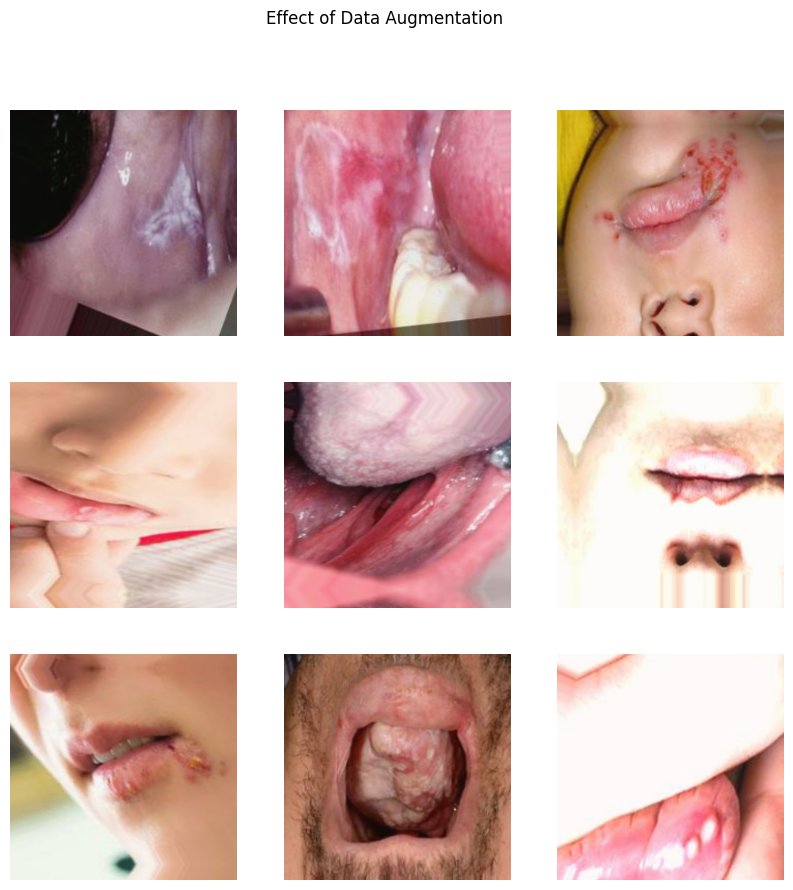

In [9]:
def plot_data_augmentation_effect(dataset, data_augmentation, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        augmented_images = data_augmentation(images)
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.suptitle('Effect of Data Augmentation')
    plt.show()

# Example Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

plot_data_augmentation_effect(train_dataset, augmentation_layer)


In [22]:
checkpoint_filepath = './ckpt/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [23]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 18)

# Experiment 1

In [24]:
cnn = Sequential([

    augmentation_layer,
    BatchNormalization(),
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(255, 255, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

In [25]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
cnn.fit(
    train_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    epochs=100,
     callbacks=[model_checkpoint_callback]
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.1769 - loss: 3.6246 - val_accuracy: 0.2111 - val_loss: 1.8517
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.2676 - loss: 1.8443 - val_accuracy: 0.2918 - val_loss: 1.8448
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.2901 - loss: 1.8087 - val_accuracy: 0.3424 - val_loss: 1.7188
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.3498 - loss: 1.6936 - val_accuracy: 0.3842 - val_loss: 1.5980
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.4099 - loss: 1.5981 - val_accuracy: 0.3891 - val_loss: 1.6156
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.4157 - loss: 1.5382 - val_accuracy: 0.4270 - val_loss: 1.5259
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.4655 - loss: 1.4241 - val_accuracy: 0.4494 - val_loss: 1.4897
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.4841 - loss: 1.3922 - val_accuracy: 0

In [27]:
metrics = pd.DataFrame(cnn.history.history)

<Axes: >

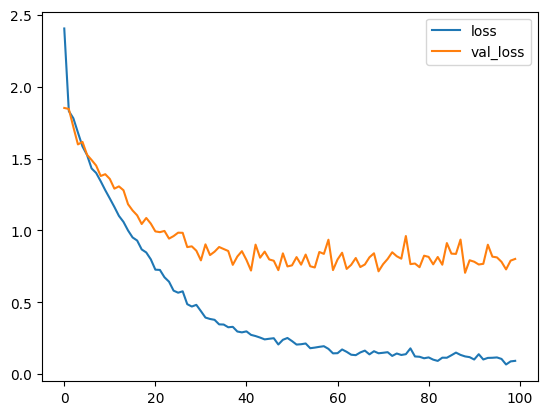

In [28]:
metrics[['loss', 'val_loss']].plot()

<Axes: >

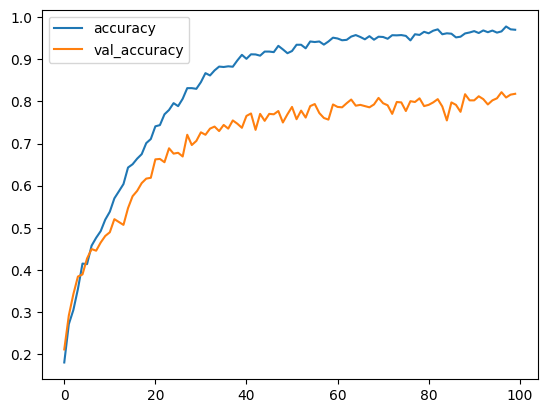

In [29]:
metrics[['accuracy', 'val_accuracy']].plot()

In [30]:
evalu = cnn
scores = evalu.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8121 - loss: 0.8808


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


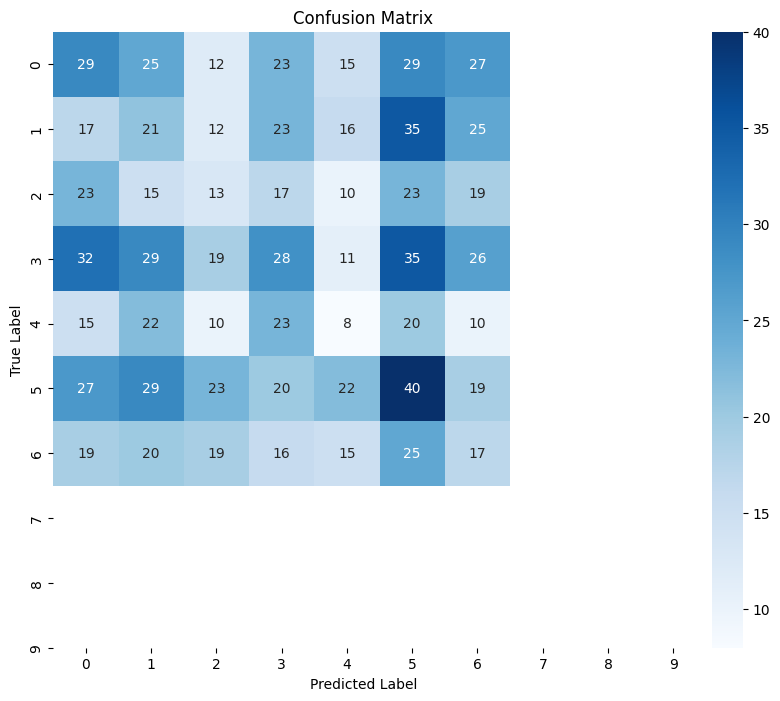

In [33]:
true_labels = []
for batch_images, batch_labels in test_dataset:
    true_labels.extend(batch_labels.numpy())  

true_labels = np.array(true_labels) 

y_pred = cnn.predict(test_dataset)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

conf_matrix = tf.math.confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Experiment 2

In [9]:
model = Sequential()

model.add(augmentation_layer)
model.add(Conv2D(filters = 32, kernel_size= (4,4), padding = 'same', input_shape = (256,256,3), activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size= (4,4), padding = 'same',activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate = 0.3))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', activation= 'relu'))
model.add(Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', activation= 'relu'))
model.add(Dropout(rate = 0.3))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.3))
model.add(Dense(7, activation='softmax'))

# opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.fit(
    train_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    epochs=100,
    callbacks = [early_stop]
)

Epoch 1/100


2024-08-18 20:21:56.731091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 338ms/step - accuracy: 0.1744 - loss: 5.7556 - val_accuracy: 0.1732 - val_loss: 2.4275
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 285ms/step - accuracy: 0.1891 - loss: 1.9367 - val_accuracy: 0.1984 - val_loss: 1.9171
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - accuracy: 0.1942 - loss: 1.9113 - val_accuracy: 0.2130 - val_loss: 1.8751
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.2051 - loss: 1.8982 - val_accuracy: 0.2072 - val_loss: 1.8743
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 286ms/step - accuracy: 0.2053 - loss: 1.8586 - val_accuracy: 0.2082 - val_loss: 1.8819
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 286ms/step - accuracy: 0.2106 - loss: 1.8668 - val_accuracy: 0.2111 - val_loss: 1.8625
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.2046 - loss: 1.8579 - val_accuracy: 0.2140 - val_loss: 1.8377
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.2019 - loss: 1.8595 - val_accuracy

In [15]:
metrics = pd.DataFrame(model.history.history)

In [16]:
metrics.head()

,accuracy,loss,val_accuracy,val_loss
0,0.186589,3.168355,0.165370,1.953682
1,0.185941,1.928412,0.174125,1.934814
2,0.190476,1.925173,0.186770,1.916744
3,0.188856,1.915288,0.185798,3.720645
4,0.176223,1.942467,0.175097,1.931956


<Axes: >

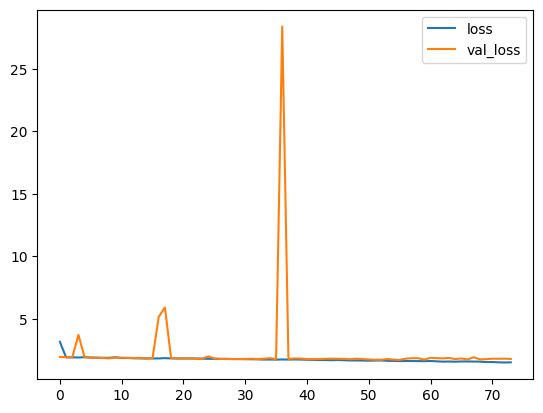

In [17]:
metrics[['loss', 'val_loss']].plot()

<Axes: >

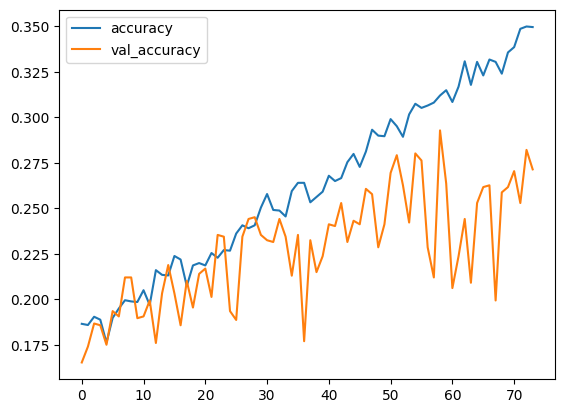

In [18]:
metrics[['accuracy', 'val_accuracy']].plot()

# **Alex Net**

In [9]:
alex_net = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Conv2D(384, (3, 3), padding='same', activation='relu'),

    Conv2D(384, (3, 3), padding='same', activation='relu'),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),

    Flatten(),

    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),

    Dense(7, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
alex_net.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
alex_net.fit(
    train_dataset,
    batch_size=32,
    validation_data=validation_dataset,
    epochs=100,
)

Epoch 1/100
 2/97 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.1562 - loss: 1006.0250

I0000 00:00:1723809444.718535     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723809444.743232     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1671 - loss: 179.4536

W0000 00:00:1723809457.748786     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - accuracy: 0.1672 - loss: 178.0823 - val_accuracy: 0.1751 - val_loss: 1.9294
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.1863 - loss: 1.9220 - val_accuracy: 0.1673 - val_loss: 1.9090
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1925 - loss: 1.9064 - val_accuracy: 0.1809 - val_loss: 1.9125
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.2171 - loss: 1.8909 - val_accuracy: 0.1887 - val_loss: 1.9374
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1979 - loss: 1.9002 - val_accuracy: 0.1732 - val_loss: 1.9102
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.2016 - loss: 1.8606 - val_accuracy: 0.2704 - val_loss: 1.7810
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.2634 - loss: 1.8098 - val_accuracy: 0.2831 - val_loss: 1.7772
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.2882 - loss: 1.7460 - val_accuracy: 0.2753 - 

In [15]:
scores = alex_net.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5237 - loss: 4.5633
